# Modelling infrastructure exposure and risk


This notebook forms the basis of "Hands-On 6" in the CCG course.

It uses the road network and flood dataset extracted in the previous tutorial.

1. Exposure - overlay sample flood extent with the network and estimate flood depth of exposure
2. Vulnerability - assume depth-damage curve (fragility curve) for the road and
   - show how the exposure is translated to damage
   - create a table with probability, flood depth, length exposed, fragility, cost/km, direct damage
4. Risk - show a risk calculation on the table and generate the result
5. Future risk - repeat with climate projections and compare with baseline

By the end of this tutorial you should be able to:
* Assess direct damage and indirect disruptions to infrastructure assets
* Apply the risk calculation to understand how to generate loss-probability curves
* Show how different flood hazards introduce uncertainty in risk estimations

In [1]:
# Imports from Python standard library
import os
from pathlib import Path

# Imports from other Python packages
import geopandas as gpd

# numpy is used by pandas and geopandas to store data in efficient arrays
# we use it in this notebook to help with trapezoidal integration
# see https://numpy.org/
import numpy as np
import pandas as pd

# seaborn helps produce more complex plots
# see https://seaborn.pydata.org/
import seaborn as sns

import snail.damages
import snail.intersection
import snail.io
from scipy.integrate import simpson

from pyproj import Geod

Change this to point to your data folder as in the previous tutorial:

In [2]:
dir = Path().resolve().parent.parent
data_folder = dir / "ghana_tutorial"
# data_folder = Path("YOUR_PATH/ghana_tutorial")

## 1. Exposure


List all the hazard files in the `flood_layer` folder:

In [3]:
hazard_paths = sorted((data_folder / "flood_layer"/"gha"/"wri_aqueduct_version_2").glob("wri*.tif"))

hazard_files = pd.DataFrame({"path": hazard_paths})
hazard_files["key"] = [Path(path).stem for path in hazard_paths]
hazard_files, grids = snail.io.extend_rasters_metadata(hazard_files)

hazard_files.head(5)[["key", "grid_id", "bands"]]

,key,grid_id,bands
0,wri_aqueduct-version_2-inuncoast_historical_wt...,0,"(1,)"
1,wri_aqueduct-version_2-inuncoast_historical_wt...,0,"(1,)"
2,wri_aqueduct-version_2-inuncoast_historical_wt...,0,"(1,)"
3,wri_aqueduct-version_2-inuncoast_historical_wt...,0,"(1,)"
4,wri_aqueduct-version_2-inuncoast_historical_wt...,0,"(1,)"


In [4]:
assert len(grids) == 1
grid = grids[0]

Read in roads again, then do intersections against all hazard scenarios.

In [5]:
roads_file = data_folder / "GHA_OSM_roads.gpkg"
roads = gpd.read_file(roads_file, layer="edges")
roads.head(2)

,osm_id,road_type,name,id,from_id,to_id,length_m,geometry
0,4790594,tertiary,Airport Road,roade_0,roadn_0,roadn_1,236.526837,"LINESTRING (-0.17544 5.6055, -0.17418 5.60555,..."
1,4790599,tertiary,South Liberation Link,roade_1,roadn_2,roadn_10777,18.539418,"LINESTRING (-0.17889 5.59979, -0.17872 5.59977)"


In [6]:
# split roads along hazard data grid

# TODO top-level "overlay_rasters"
# TODO for vector in vectors / for raster in rasters "overlay_raster"


# push into split_linestrings, flag to disable
prepared = snail.intersection.prepare_linestrings(roads)

flood_intersections = snail.intersection.split_linestrings(prepared, grid)

# push into split_linestrings
flood_intersections = snail.intersection.apply_indices(
    flood_intersections, grid, index_i="i_0", index_j="j_0"
)

flood_intersections = snail.io.associate_raster_files(
    flood_intersections, hazard_files
)

# calculate the length of each stretch of road
# don't include in snail wrapper top-level function
geod = Geod(ellps="WGS84")
flood_intersections["length_m"] = flood_intersections.geometry.apply(
    geod.geometry_length
)

In [7]:
# save to file
output_file = (
    data_folder
    / "results"
    / Path(roads_file).name.replace(
        ".gpkg", "_edges___exposure.geoparquet"
    )
)

flood_intersections.to_parquet(output_file)

In [8]:
list(flood_intersections.columns)[:21]

['osm_id',
 'road_type',
 'name',
 'id',
 'from_id',
 'to_id',
 'length_m',
 'geometry',
 'split',
 'i_0',
 'j_0',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0001_5-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0002_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0005_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0010_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0025_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0050_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0100_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0250_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0500_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp1000_0-gha']

In [9]:
data_cols = [col for col in flood_intersections.columns if "wri" in col]

In [10]:
data_cols[:20]

['wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0001_5-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0002_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0005_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0010_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0025_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0050_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0100_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0250_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0500_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp1000_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2050_rp0001_5-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2050_rp0002_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2050_rp0005_0-gha',
 'wri_aqueduct-version_2-inuncoast_historical_wtsub_2050_rp0010_

In [11]:
# find any max depth and filter > 0
all_intersections = flood_intersections[
    flood_intersections[data_cols].max(axis=1) > 0
]
# subset columns
all_intersections = all_intersections.drop(
    columns=["osm_id", "name", "from_id", "to_id", "geometry", "i_0", "j_0"]
)
# melt and check again for depth
all_intersections = all_intersections.melt(
    id_vars=["id", "split", "road_type", "length_m"],
    value_vars=data_cols,
    var_name="key",
    value_name="depth_m",
).query("depth_m > 0")

all_intersections.head(5)

,id,split,road_type,length_m,key,depth_m
430,roade_1394,9,tertiary,153.153316,wri_aqueduct-version_2-inuncoast_historical_wt...,0.466355
431,roade_1394,10,tertiary,28.151241,wri_aqueduct-version_2-inuncoast_historical_wt...,1.349324
435,roade_1413,9,tertiary,412.834012,wri_aqueduct-version_2-inuncoast_historical_wt...,0.006246
440,roade_1417,3,primary,929.965564,wri_aqueduct-version_2-inuncoast_historical_wt...,0.516396
442,roade_1417,5,primary,921.598630,wri_aqueduct-version_2-inuncoast_historical_wt...,0.407549


In [12]:
river = all_intersections[all_intersections.key.str.contains("inunriver")]
coast = all_intersections[all_intersections.key.str.contains("inuncoast")]

coast_keys = coast.key.str.extract(
    r"wri_aqueduct-version_2-(?P<hazard>\w+)_(?P<rcp>[^_]+)_(?P<sub>[^_]+)_(?P<epoch>[^_]+)_rp(?P<rp>[^-]+)-gha"
)
coast = pd.concat([coast, coast_keys], axis=1)
river_keys = river.key.str.extract(
    r"wri_aqueduct-version_2-(?P<hazard>\w+)_(?P<rcp>[^_]+)_(?P<gcm>[^_]+)_(?P<epoch>[^_]+)_rp(?P<rp>[^-]+)-gha"
)
river = pd.concat([river, river_keys], axis=1)

In [13]:
coast.rp = coast.rp.apply(lambda rp: float(rp.replace("_", ".").lstrip("0")))
coast.head(5)

,id,split,road_type,length_m,key,depth_m,hazard,rcp,sub,epoch,rp
430,roade_1394,9,tertiary,153.153316,wri_aqueduct-version_2-inuncoast_historical_wt...,0.466355,inuncoast,historical,wtsub,2030,1.5
431,roade_1394,10,tertiary,28.151241,wri_aqueduct-version_2-inuncoast_historical_wt...,1.349324,inuncoast,historical,wtsub,2030,1.5
435,roade_1413,9,tertiary,412.834012,wri_aqueduct-version_2-inuncoast_historical_wt...,0.006246,inuncoast,historical,wtsub,2030,1.5
440,roade_1417,3,primary,929.965564,wri_aqueduct-version_2-inuncoast_historical_wt...,0.516396,inuncoast,historical,wtsub,2030,1.5
442,roade_1417,5,primary,921.598630,wri_aqueduct-version_2-inuncoast_historical_wt...,0.407549,inuncoast,historical,wtsub,2030,1.5


In [14]:
# river.rp = river.rp.apply(lambda rp: float(rp.replace("_", ".").lstrip("0")))
river.gcm = river.gcm.str.replace("0", "")
river.head(5)

,id,split,road_type,length_m,key,depth_m,hazard,rcp,gcm,epoch,rp
547824,roade_55,0,trunk,256.660267,wri_aqueduct-version_2-inunriver_historical_00...,2.243539,inunriver,historical,WATCH,1980,00005
547826,roade_126,0,trunk,364.644366,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005
547827,roade_126,1,trunk,158.050565,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005
547828,roade_127,0,trunk,54.297481,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005
547829,roade_128,0,trunk,715.652789,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005


Summarise total length of roads exposed to depth 2m or greater river flooding, under different return periods and climate scenarios:


In [15]:
summary = (
    river[river.depth_m >= 2.0]
    .drop(columns=["id", "split", "road_type", "key"])
    .groupby(["hazard", "rcp", "gcm", "epoch", "rp"])
    .sum()
    .drop(columns=["depth_m"])
)

summary

length_m
hazard    rcp        gcm       epoch rp                  
inunriver historical WATCH     1980  00005  278185.204955
                                     00010  458024.929099
                                     00025  516672.545158
                                     00050  552825.932679
                                     00100  583449.265549
...                                                   ...
          rcp8p5     NorESM1-M 2080  00050  306446.190164
                                     00100  346057.864928
                                     00250  407998.269230
                                     00500  503666.482039
                                     01000  571243.766343

[208 rows x 1 columns]

Plot exposure against return period, with separate plot areas for each Representative Concentration Pathway (RCP), and different colours for the different Global Climate Models (GCM): 

In [16]:
plot_data = summary.reset_index()
plot_data = plot_data[plot_data.epoch.isin(["1980", "2080"])]
plot_data.rp = plot_data.rp.apply(lambda rp: int(rp.lstrip("0")))
plot_data["probability"] = 1 / plot_data.rp
plot_data.head(5)

,hazard,rcp,gcm,epoch,rp,length_m,probability
0,inunriver,historical,WATCH,1980,5,278185.204955,0.20
1,inunriver,historical,WATCH,1980,10,458024.929099,0.10
2,inunriver,historical,WATCH,1980,25,516672.545158,0.04
3,inunriver,historical,WATCH,1980,50,552825.932679,0.02
4,inunriver,historical,WATCH,1980,100,583449.265549,0.01


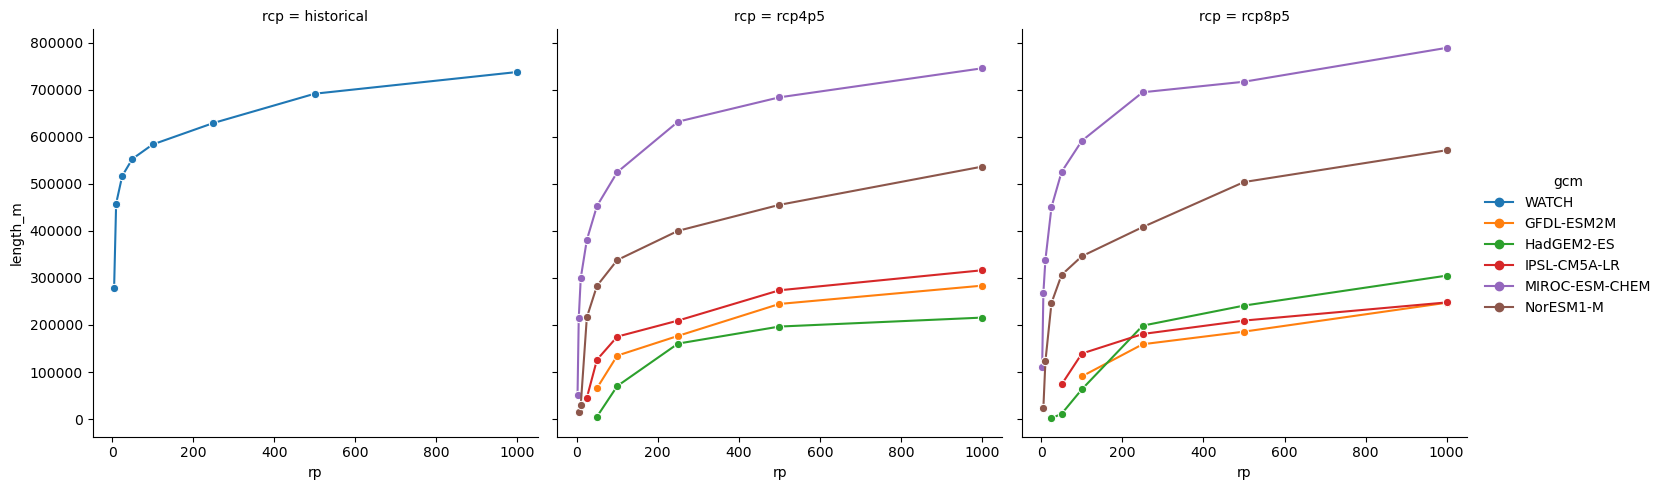

In [17]:
sns.relplot(
    data=plot_data,
    x="rp",
    y="length_m",
    hue="gcm",
    col="rcp",
    kind="line",
    marker="o",
)

## 2. Vulnerability

Set up fragility curve assumptions, where probability of damage (`pfail`) depends on whether a road is paved and the depth of flood it is exposed to. 

These assumptions are derived from Koks, E.E., Rozenberg, J., Zorn, C. et al. A global multi-hazard risk analysis of road and railway infrastructure assets. Nat Commun 10, 2677 (2019). https://doi.org/10.1038/s41467-019-10442-3, Figure S3, extrapolated to 2m and 3m depths. 

The analysis is likely to be highly sensitive to these assumptions, and this approach is strongly limited by the availability and quality of fragility data, as well as the assumption that fragility can be related to flood depth alone - flood water velocity would be an important factor in a more detailed vulnerability assessment. 

In [18]:
paved = snail.damages.PiecewiseLinearDamageCurve(
    pd.DataFrame(
        {
            "intensity": [0.0, 0.999999999, 1, 2, 3],
            "damage": [0.0, 0.0, 0.1, 0.3, 0.5],
        }
    )
)
unpaved = snail.damages.PiecewiseLinearDamageCurve(
    pd.DataFrame(
        {
            "intensity": [0.0, 0.999999999, 1, 2, 3],
            "damage": [0.0, 0.0, 0.9, 1.0, 1.0],
        }
    )
)
paved, unpaved

(<snail.damages.PiecewiseLinearDamageCurve at 0x75242c8b16a0>,
 <snail.damages.PiecewiseLinearDamageCurve at 0x75242c921590>)

(<Axes: xlabel='Hazard Intensity', ylabel='Damage Fraction'>,
 <Axes: xlabel='Hazard Intensity', ylabel='Damage Fraction'>)

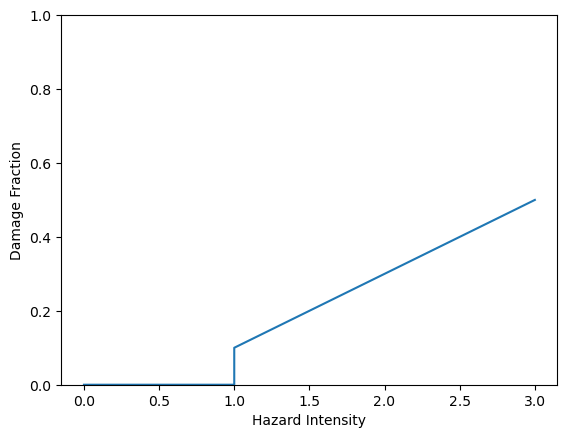

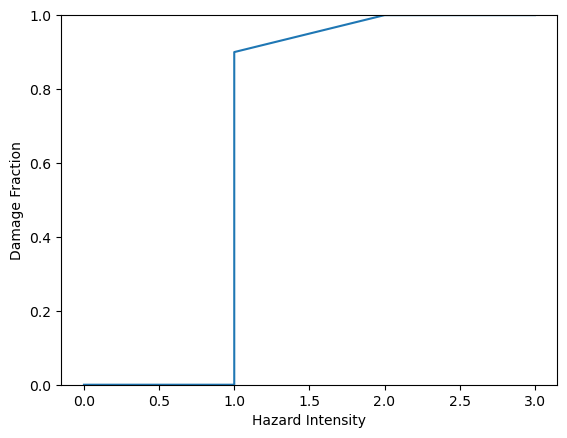

In [19]:
paved.plot(), unpaved.plot()

Set up cost assumptions. 

These are taken from Koks et al (2019) again, Table S8, construction costs to be assumed as an estimate of full rehabilitation after flood damage. 

Again the analysis is likely to be highly sensitive to these assumptions, which should be replaced by better estimates if available.

In [20]:
costs = pd.DataFrame(
    {
        "kind": ["paved_four_lane", "paved_two_lane", "unpaved"],
        "cost_usd_per_km": [3_800_000, 932_740, 22_780],
    }
)
costs

,kind,cost_usd_per_km
0,paved_four_lane,3800000
1,paved_two_lane,932740
2,unpaved,22780


Set up assumptions about which roads are paved or unpaved, and number of lanes.

In [21]:
sorted(river.road_type.unique())

['motorway',
 'motorway_link',
 'primary',
 'primary_link',
 'secondary',
 'secondary_link',
 'tertiary',
 'tertiary_link',
 'trunk',
 'trunk_link']

Assume all `tertiary` roads are unpaved, all others are paved.

In [22]:
river["paved"] = ~(river.road_type == "tertiary")

In [23]:
def kind(road_type):
    if road_type in ("trunk", "trunk_link", "motorway"):
        return "paved_four_lane"
    elif road_type in ("primary", "primary_link", "secondary"):
        return "paved_two_lane"
    else:
        return "unpaved"


river["kind"] = river.road_type.apply(kind)

In [24]:
river = river.merge(costs, on="kind")

Use the damage curve to estimate `proportion_damaged` for each exposed section.

In [25]:
river.head(2)

,id,split,road_type,length_m,key,depth_m,hazard,rcp,gcm,epoch,rp,paved,kind,cost_usd_per_km
0,roade_55,0,trunk,256.660267,wri_aqueduct-version_2-inunriver_historical_00...,2.243539,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000
1,roade_126,0,trunk,364.644366,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000


In [26]:
paved_depths = river.loc[river.paved, "depth_m"]
paved_damage = paved.damage_fraction(paved_depths)
river.loc[river.paved, "proportion_damaged"] = paved_damage

unpaved_depths = river.loc[~river.paved, "depth_m"]
unpaved_damage = paved.damage_fraction(unpaved_depths)
river.loc[~river.paved, "proportion_damaged"] = unpaved_damage

Finally estimate cost of rehabilitation for each exposed section

In [27]:
river["damage_usd"] = river.length_m * river.cost_usd_per_km * 1e-3
river.head(2)

,id,split,road_type,length_m,key,depth_m,hazard,rcp,gcm,epoch,rp,paved,kind,cost_usd_per_km,proportion_damaged,damage_usd
0,roade_55,0,trunk,256.660267,wri_aqueduct-version_2-inunriver_historical_00...,2.243539,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000,0.348708,9.753090e+05
1,roade_126,0,trunk,364.644366,wri_aqueduct-version_2-inunriver_historical_00...,0.073757,inunriver,historical,WATCH,1980,00005,True,paved_four_lane,3800000,0.000000,1.385649e+06


In [28]:
river.to_csv(data_folder / "results" / "inunriver_damages_rp.csv", index=False)

In [29]:
summary = (
    river.drop(
        columns=[
            "id",
            "split",
            "length_m",
            "key",
            "depth_m",
            "paved",
            "kind",
            "cost_usd_per_km",
            "proportion_damaged",
        ]
    )
    .groupby(["road_type", "hazard", "rcp", "gcm", "epoch", "rp"])
    .sum()
)
summary

damage_usd
road_type  hazard    rcp        gcm       epoch rp                 
motorway   inunriver historical WATCH     1980  00005  2.848222e+07
                                                00010  2.848222e+07
                                                00025  2.848222e+07
                                                00050  2.848222e+07
                                                00100  2.848222e+07
...                                                             ...
trunk_link inunriver rcp8p5     NorESM1-M 2080  00050  1.512558e+07
                                                00100  1.512558e+07
                                                00250  1.512558e+07
                                                00500  1.512558e+07
                                                01000  1.512558e+07

[2780 rows x 1 columns]

## 3. Risk

Calculate expected annual damages for each road under historical hazard.

Start by selecting only historical intersections, and keeping only the road ID, return period, and cost of rehabilitation if damaged.

In [30]:
historical = river[river.rcp == "historical"][["id", "rp", "damage_usd"]]

Sum up the expected damage for each road, per return period, then pivot the table to create columns for each return period - now there is one row per road.

In [31]:
historical = historical.groupby(["id", "rp"]).sum().reset_index()
historical = historical.pivot(index="id", columns="rp").replace(
    float("NaN"), 0
)
historical.columns = [f"rp{int(rp)}" for _, rp in historical.columns]
historical.head(2)

,rp5,rp10,rp25,rp50,rp100,rp250,rp500,rp1000
id,,,,,,,,
roade_10001,386658.527135,386658.527135,386658.527135,386658.527135,386658.527135,386658.527135,386658.527135,386658.527135
roade_10002,11485.501119,11485.501119,11485.501119,11485.501119,11485.501119,11485.501119,11485.501119,11485.501119


Calculate expected annual damages, integrating under the expected damage curve over return periods.

In [32]:
def calculate_ead(df):
    rp_cols = sorted(
        list(df.columns), key=lambda col: 1 / int(col.replace("rp", ""))
    )
    rps = np.array([int(col.replace("rp", "")) for col in rp_cols])
    probabilities = 1 / rps
    rp_damages = df[rp_cols]
    return simpson(rp_damages, x=probabilities, axis=1)


historical["ead_usd"] = calculate_ead(historical)
historical.head(2)

,rp5,rp10,rp25,rp50,rp100,rp250,rp500,rp1000,ead_usd
id,,,,,,,,,
roade_10001,386658.527135,386658.527135,386658.527135,386658.527135,386658.527135,386658.527135,386658.527135,386658.527135,76945.046900
roade_10002,11485.501119,11485.501119,11485.501119,11485.501119,11485.501119,11485.501119,11485.501119,11485.501119,2285.614723


In [33]:
historical.to_csv(data_folder / "results" / "inunriver_damages_ead__historical.csv")

## 4. Future risk

Calculate expected annual damages under each future scenario (for each global climate model and representative concentration pathway).

This follows the same method as for historical flooding above, with the added variables of climate model and rcp.

In [34]:
future = river[["id", "rp", "rcp", "gcm", "epoch", "damage_usd"]].copy()

Sum up the expected damage for each road, per return period, gcm and rcp

In [35]:
future = (
    future.groupby(["id", "rp", "rcp", "gcm", "epoch"]).sum().reset_index()
)
future.head(2)

,id,rp,rcp,gcm,epoch,damage_usd
0,roade_10001,00002,rcp4p5,GFDL-ESM2M,2030,386658.527135
1,roade_10001,00002,rcp4p5,GFDL-ESM2M,2050,386658.527135


Pivot the table to create columns for each return period - now there is one row per road, gcm and rcp.

In [36]:
future = future.pivot(
    index=["id", "rcp", "gcm", "epoch"], columns="rp"
).replace(float("NaN"), 0)
future.columns = [f"rp{int(rp)}" for _, rp in future.columns]
future.head(2)

rp2            rp5  \
id          rcp        gcm        epoch                                 
roade_10001 historical WATCH      1980        0.000000  386658.527135   
            rcp4p5     GFDL-ESM2M 2030   386658.527135  386658.527135   

                                                  rp10           rp25  \
id          rcp        gcm        epoch                                 
roade_10001 historical WATCH      1980   386658.527135  386658.527135   
            rcp4p5     GFDL-ESM2M 2030   386658.527135  386658.527135   

                                                  rp50          rp100  \
id          rcp        gcm        epoch                                 
roade_10001 historical WATCH      1980   386658.527135  386658.527135   
            rcp4p5     GFDL-ESM2M 2030   386658.527135  386658.527135   

                                                 rp250          rp500  \
id          rcp        gcm        epoch                                 
roade_10001 historical WATCH      1980   386658.527135  386658.527135   
            rcp4p5     GFDL-ESM2M 2030   386658.527135  386658.527135   

                                                rp1000  
id          rcp        gcm        epoch                 
roade_10001 historical WATCH      1980   386658.527135  
            rcp4p5     GFDL-ESM2M 2030   386658.527135

Calculate expected annual damages, integrating under the expected damage curve over return periods.

In [37]:
future["ead_usd"] = calculate_ead(future)

In [38]:
future.to_csv(data_folder / "results" / "inunriver_damages_ead.csv")

Pick out an individual road by id, to spot check uncertainty:

In [39]:
future.reset_index().id.unique()

array(['roade_10001', 'roade_10002', 'roade_10011', ..., 'roade_9925',
       'roade_9926', 'roade_9930'], shape=(2363,), dtype=object)

In [40]:
# future.loc["roade_1002"]

Summarise total expected annual (direct) damages, showing variation between climate models and representative concentration pathways.

In [41]:
summary = (
    future.reset_index()[["rcp", "gcm", "epoch", "ead_usd"]]
    .groupby(["rcp", "gcm", "epoch"])
    .sum()
    .reset_index()
)
summary.epoch = summary.epoch.astype(int)
summary.head()

,rcp,gcm,epoch,ead_usd
0,historical,WATCH,1980,5.679075e+08
1,rcp4p5,GFDL-ESM2M,2030,6.031936e+08
2,rcp4p5,GFDL-ESM2M,2050,6.025140e+08
3,rcp4p5,GFDL-ESM2M,2080,5.912566e+08
4,rcp4p5,HadGEM2-ES,2030,6.193782e+08


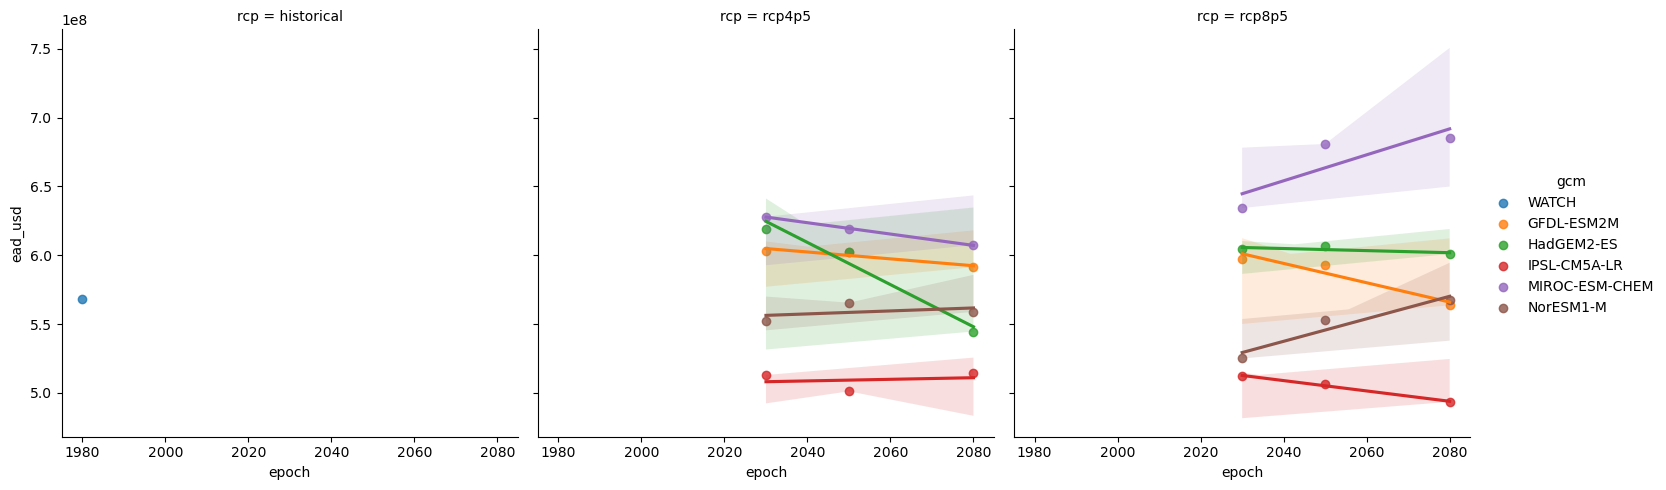

In [42]:
sns.lmplot(
    data=summary,
    col="rcp",
    x="epoch",
    y="ead_usd",
    hue="gcm",  # fit_reg=False
)